In [1]:
################################################################################################################################################
# Modelling gross private domestic investment (GPDI) from Federal Reserve Economic Datasets:
# Gradient boosting combines multiple decision trees that learn from their errors to improve the overall accuracy of the model.
# GBM uses a gradient descent optimization algorithm to iteratively improve the model, calculating slope of the loss function and 
# updating the parameters in the direction of the negative slope until the model converges to a minimum 
################################################################################################################################################
# import libraries
import glob
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
########################################################################
# pre-processing: read in all files into dfs within a dict, clean and plot
########################################################################
folder="C:/Users/bcm9/Documents/Py_code/Data/FRED/"
filelist = glob.glob(os.path.join(folder, "*.xls"))
print(filelist)

['C:/Users/bcm9/Documents/Py_code/Data/FRED\\BOPGSTB.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\CPALTT01USM657N.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GDPC1.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GPDI.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\PCECC96.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\UNRATE.xls']


In [3]:
# create empty dictionary 
df_dict = {}

# append datasets into the list
for file in filelist:
    df = pd.read_excel(file)
    # get the name of the csv without the '.csv' extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df_dict[filename] = df

In [4]:
for key in df_dict.keys():
    df = df_dict[key]
    df = df.loc[10:, :].copy()
    df['date'] = pd.to_datetime(df['FRED Graph Observations'])
    df_dict[key] = df

In [5]:
# drop all original date format from df and rename columns for later identification
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop('FRED Graph Observations', axis=1)
    df_dict[key]=df_dict[key].rename(columns={"Unnamed: 1": key})

In [6]:
########################################################################
# model pre-processing
########################################################################
# merge data, join based on date
df = df_dict['GPDI'].merge(df_dict['UNRATE'], on='date')
df = df.merge(df_dict['PCECC96'], on='date')
df = df.merge(df_dict['GDPC1'], on='date')
df = df.merge(df_dict['CPALTT01USM657N'], on='date')
df = df.merge(df_dict['BOPGSTB'], on='date')

# drop rows with missing values
df = df.dropna()

# replace missing values with 0
if df.isna().any().any():
    df = df.fillna(0) 

# make types float64    
df = df.astype({'UNRATE': 'float64', 'PCECC96': 'float64',
                'GDPC1': 'float64', 'CPALTT01USM657N': 'float64',
                'BOPGSTB': 'float64', 'GPDI': 'float64'})

# set dependent and independent variables
y = df['GPDI']
X = df[['UNRATE', 'PCECC96', 'GDPC1', 'CPALTT01USM657N', 'BOPGSTB']]

In [7]:
# split features (X) and target variable (y) into training, validation, and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
########################################################################
# instantiate, fit GBM model
########################################################################
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [9]:
# test model on the validation set
y_test = gbm.predict(X_train)
mse = mean_squared_error(y_train, y_test)
r2 = r2_score(y_train, y_test)
print('MSE:', mse)
print('R-squared:', r2)

MSE: 38.996480799817945
R-squared: 0.9999511457305642


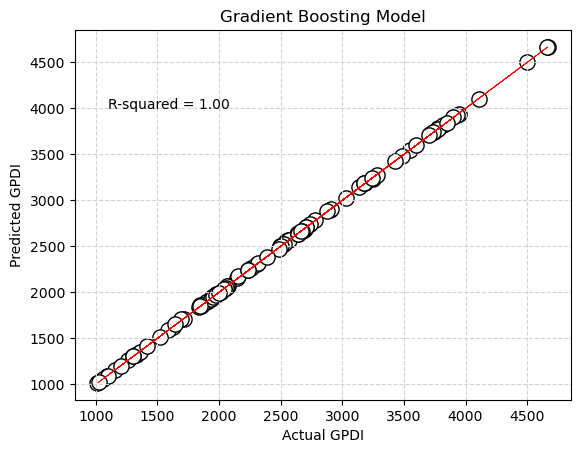

In [10]:
# plot actual vs predicted
plt.scatter(y_train, y_test, s=120, edgecolor='k',facecolor='w')
plt.grid(color='lightgray', linestyle='--')
plt.xlabel('Actual GPDI')
plt.ylabel('Predicted GPDI')
plt.title('Gradient Boosting Model')
plt.text(1100, 4000, 'R-squared = {:.2f}'.format(r2))
# add ls line
slope, intercept = np.polyfit(y_train, y_test, 1)
plt.plot(y_test, slope*y_test + intercept, 'r--', linewidth=.5)
plt.show()

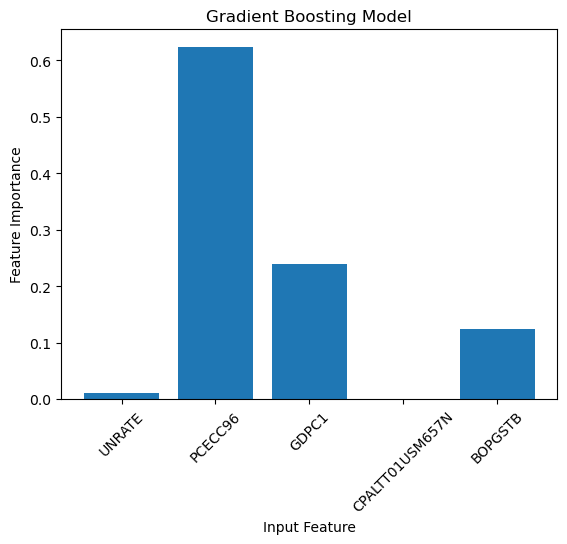

In [11]:
########################################################################
# calculate feature importance
########################################################################
importance = gbm.feature_importances_

# plot feature importance
plt.bar(X.columns, importance)
plt.xticks(rotation=45)
plt.xlabel('Input Feature')
plt.ylabel('Feature Importance')
plt.title('Gradient Boosting Model')
plt.show()